### RNN Model for Stock Analysis

1. import data from csv datsets
    - prices
    - sector and industry 
    - revenue
    - profit
2. compile into timestep sequence
3. create lagged y-value set
4. create model
    - lstm cell
    - dense layer
    - consider another lstm and dense layer
    - output
5. run model based on following inputs for each time step
    - market cap
    - industry (one-hot vector)
    - sector (one-hot vector)
    - revenue
    - profit
6. predict
    - run model up until the known value is done
    - iterate through following values feeding previous output and hidden state

#### Initialize definitions

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

# using tensorflow.keras may be necessary, keras by itself may not work
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, TimeDistributed, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

In [2]:
# define constants and filepaths

shareprices_path = 'data/us-shareprices-daily.csv'
# shareprices_path = 'us-shareprices-latest.csv' # latest data only, helps shorten load time while developing

MAX_DAYS = 9000 # number of total days possible for a stock
T_x = 180 # number of timesteps
T_y = 1 # number of outputs, T_x = T_y, or 1, depending on the architecture
n_a = 64 # number of hidden activation units
n_values = 1 # number of output predicted variables
n_trailing = T_x # number of trailing days used for prediction
n_lag = 15 # number of timesteps in advance for forward prediction
m = 1500 # number of training examples

sc = MinMaxScaler(feature_range=(0,1))

Data Preparation:

1. Import all datasets using pandas
2. Add revenue, profit, and yoy growth by quarter to dataset
    - Make data repeat until following quarter
3. Create a second dataset with sector of the company
4. Slice dataset into arrays of length T_x+1 and pair with sector

In [302]:
cols = ['Ticker', 'SimFinId', 'Fiscal Year', 'Fiscal Period', 'Report Date', 'Revenue', 'Gross Profit', 'Net Income']
df = pd.read_csv('data/us-income-quarterly.csv', delimiter=';', usecols=cols)
df

,Ticker,SimFinId,Fiscal Year,Fiscal Period,Report Date,Revenue,Gross Profit,Net Income
0,A,45846,2010,Q3,2010-07-31,1.384000e+09,725000000.0,205000000
1,A,45846,2010,Q4,2010-10-31,1.576000e+09,834000000.0,292000000
2,A,45846,2011,Q1,2011-01-31,1.519000e+09,816000000.0,193000000
3,A,45846,2011,Q2,2011-04-30,1.677000e+09,900000000.0,200000000
4,A,45846,2011,Q3,2011-07-31,1.691000e+09,892000000.0,330000000
...,...,...,...,...,...,...,...,...
65919,ZYXI,171401,2018,Q4,2018-12-31,9.337000e+06,7506000.0,2622000
65920,ZYXI,171401,2019,Q1,2019-03-31,9.196000e+06,7412000.0,2350000
65921,ZYXI,171401,2019,Q2,2019-06-30,1.029700e+07,8349000.0,2162000
65922,ZYXI,171401,2019,Q3,2019-09-30,1.181700e+07,9556000.0,2031000


In [329]:
df = pd.read_csv('data/us-income-ttm.csv', delimiter=';')
df

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
0,A,45846,USD,2010,Q3,2010-07-31,2010-10-06,2011-09-07,346500000.0,350750000.0,...,-33000000.0,-77000000.0,401000000,127000000.0,528000000,-111000000.0,417000000,NaN,417000000,417000000
1,A,45846,USD,2010,Q4,2010-10-31,2010-12-20,2012-12-20,346750000.0,354000000.0,...,-6000000.0,-76000000.0,560000000,132000000.0,692000000,-8000000.0,684000000,NaN,684000000,684000000
2,A,45846,USD,2011,Q1,2011-01-31,2011-03-09,2012-03-05,346500000.0,354250000.0,...,-8000000.0,-75000000.0,675000000,132000000.0,807000000,-9000000.0,798000000,NaN,798000000,798000000
3,A,45846,USD,2011,Q2,2011-04-30,2011-06-07,2012-06-04,346250000.0,354500000.0,...,1000000.0,-73000000.0,796000000,132000000.0,928000000,-38000000.0,890000000,NaN,890000000,890000000
4,A,45846,USD,2011,Q3,2011-07-31,2011-09-07,2012-09-05,346500000.0,355750000.0,...,16000000.0,-69000000.0,977000000,5000000.0,982000000,33000000.0,1015000000,NaN,1015000000,1015000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65480,ZYXI,171401,USD,2018,Q4,2018-12-31,2019-02-26,2019-02-26,32503000.0,34043000.0,...,-154000.0,-154000.0,10216000,NaN,10216000,-664000.0,9552000,NaN,9552000,9552000
65481,ZYXI,171401,USD,2019,Q1,2019-03-31,2019-04-30,2019-04-30,32411000.0,33869750.0,...,-39000.0,-39000.0,10632000,880000.0,11512000,-1531000.0,9981000,NaN,9981000,9981000
65482,ZYXI,171401,USD,2019,Q2,2019-06-30,2019-07-31,2019-07-31,32337500.0,33815750.0,...,-2000.0,-2000.0,10538000,880000.0,11418000,-1693000.0,9725000,NaN,9725000,9725000
65483,ZYXI,171401,USD,2019,Q3,2019-09-30,2019-10-29,2019-10-29,32329750.0,33852000.0,...,-2000.0,-2000.0,10213000,880000.0,11093000,-1928000.0,9165000,NaN,9165000,9165000


In [330]:
df['Report Date']
df.index = pd.to_datetime(df.pop('Report Date'))

In [331]:
df.head()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
Report Date,,,,,,,,,,,,,,,,,,,,,
2010-07-31,A,45846,USD,2010,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000,127000000.0,528000000,-111000000.0,417000000,NaN,417000000,417000000
2010-10-31,A,45846,USD,2010,Q4,2010-12-20,2012-12-20,346750000.0,354000000.0,5.444000e+09,...,-6000000.0,-76000000.0,560000000,132000000.0,692000000,-8000000.0,684000000,NaN,684000000,684000000
2011-01-31,A,45846,USD,2011,Q1,2011-03-09,2012-03-05,346500000.0,354250000.0,5.750000e+09,...,-8000000.0,-75000000.0,675000000,132000000.0,807000000,-9000000.0,798000000,NaN,798000000,798000000
2011-04-30,A,45846,USD,2011,Q2,2011-06-07,2012-06-04,346250000.0,354500000.0,6.156000e+09,...,1000000.0,-73000000.0,796000000,132000000.0,928000000,-38000000.0,890000000,NaN,890000000,890000000
2011-07-31,A,45846,USD,2011,Q3,2011-09-07,2012-09-05,346500000.0,355750000.0,6.463000e+09,...,16000000.0,-69000000.0,977000000,5000000.0,982000000,33000000.0,1015000000,NaN,1015000000,1015000000


In [332]:
expand = lambda x: x.asfreq('1D').pad()
newdf = df.groupby('Ticker').apply(expand)
newdf.loc['A']

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
Report Date,,,,,,,,,,,,,,,,,,,,,
2010-07-31,A,45846.0,USD,2010.0,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000.0,127000000.0,528000000.0,-111000000.0,4.170000e+08,NaN,4.170000e+08,4.170000e+08
2010-08-01,A,45846.0,USD,2010.0,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000.0,127000000.0,528000000.0,-111000000.0,4.170000e+08,NaN,4.170000e+08,4.170000e+08
2010-08-02,A,45846.0,USD,2010.0,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000.0,127000000.0,528000000.0,-111000000.0,4.170000e+08,NaN,4.170000e+08,4.170000e+08
2010-08-03,A,45846.0,USD,2010.0,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000.0,127000000.0,528000000.0,-111000000.0,4.170000e+08,NaN,4.170000e+08,4.170000e+08
2010-08-04,A,45846.0,USD,2010.0,Q3,2010-10-06,2011-09-07,346500000.0,350750000.0,5.035000e+09,...,-33000000.0,-77000000.0,401000000.0,127000000.0,528000000.0,-111000000.0,4.170000e+08,NaN,4.170000e+08,4.170000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,A,45846.0,USD,2019.0,Q4,2019-12-19,2019-12-19,314000000.0,318000000.0,5.163000e+09,...,-22000000.0,-38000000.0,919000000.0,5000000.0,919000000.0,152000000.0,1.071000e+09,0.0,1.071000e+09,1.071000e+09
2020-01-28,A,45846.0,USD,2019.0,Q4,2019-12-19,2019-12-19,314000000.0,318000000.0,5.163000e+09,...,-22000000.0,-38000000.0,919000000.0,5000000.0,919000000.0,152000000.0,1.071000e+09,0.0,1.071000e+09,1.071000e+09
2020-01-29,A,45846.0,USD,2019.0,Q4,2019-12-19,2019-12-19,314000000.0,318000000.0,5.163000e+09,...,-22000000.0,-38000000.0,919000000.0,5000000.0,919000000.0,152000000.0,1.071000e+09,0.0,1.071000e+09,1.071000e+09


In [333]:
print(newdf.loc['AAPL']['Revenue'])

Report Date
2001-03-31    6.133000e+09
2001-04-01    6.133000e+09
2001-04-02    6.133000e+09
2001-04-03    6.133000e+09
2001-04-04    6.133000e+09
                  ...     
2019-12-27    2.601740e+11
2019-12-28    2.601740e+11
2019-12-29    2.601740e+11
2019-12-30    2.601740e+11
2019-12-31    2.676830e+11
Name: Revenue, Length: 6850, dtype: float64


In [314]:
for ticker, group in df.groupby('Ticker'):
    df2.loc[ticker] = group.asfreq('1D').pad()

In [315]:
df2

Abnormal Gains (Losses)  Cost of Revenue  \
Ticker Report Date                                             
A      2010-07-31                       NaN              NaN   
       2010-10-31                       NaN              NaN   
       2011-01-31                       NaN              NaN   
       2011-04-30                       NaN              NaN   
       2011-07-31                       NaN              NaN   
...                                     ...              ...   
ZYXI   2018-12-31                       NaN              NaN   
       2019-03-31                       NaN              NaN   
       2019-06-30                       NaN              NaN   
       2019-09-30                       NaN              NaN   
       2019-12-31                       NaN              NaN   

                    Depreciation & Amortization  Fiscal Year  Gross Profit  \
Ticker Report Date                                                           
A      2010-07-31                           NaN          NaN           NaN   
       2010-10-31                           NaN          NaN           NaN   
       2011-01-31                           NaN          NaN           NaN   
       2011-04-30                           NaN          NaN           NaN   
       2011-07-31                           NaN          NaN           NaN   
...                                         ...          ...           ...   
ZYXI   2018-12-31                           NaN          NaN           NaN   
       2019-03-31                           NaN          NaN           NaN   
       2019-06-30                           NaN          NaN           NaN   
       2019-09-30                           NaN          NaN           NaN   
       2019-12-31                           NaN          NaN           NaN   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
A      2010-07-31                                        NaN   
       2010-10-31                                        NaN   
       2011-01-31                                        NaN   
       2011-04-30                                        NaN   
       2011-07-31                                        NaN   
...                                                      ...   
ZYXI   2018-12-31                                        NaN   
       2019-03-31                                        NaN   
       2019-06-30                                        NaN   
       2019-09-30                                        NaN   
       2019-12-31                                        NaN   

                    Income Tax (Expense) Benefit, Net  Interest Expense, Net  \
Ticker Report Date                                                             
A      2010-07-31                                 NaN                    NaN   
       2010-10-31                                 NaN                    NaN   
       2011-01-31                                 NaN                    NaN   
       2011-04-30                                 NaN                    NaN   
       2011-07-31                                 NaN                    NaN   
...                                               ...                    ...   
ZYXI   2018-12-31                                 NaN                    NaN   
       2019-03-31                                 NaN                    NaN   
       2019-06-30                                 NaN                    NaN   
       2019-09-30                                 NaN                    NaN   
       2019-12-31                                 NaN                    NaN   

                    Net Extraordinary Gains (Losses)  Net Income  ...  \
Ticker Report Date                                                ...   
A      2010-07-31                                NaN         NaN  ...   
       2010-10-31                                NaN         NaN  ...   
      

In [312]:
df2.loc['A']

,Abnormal Gains (Losses),Cost of Revenue,Depreciation & Amortization,Fiscal Year,Gross Profit,Income (Loss) from Continuing Operations,"Income Tax (Expense) Benefit, Net","Interest Expense, Net",Net Extraordinary Gains (Losses),Net Income,...,Operating Expenses,Operating Income (Loss),Pretax Income (Loss),"Pretax Income (Loss), Adj.",Research & Development,Revenue,"Selling, General & Administrative",Shares (Basic),Shares (Diluted),SimFinId
Report Date,,,,,,,,,,,,,,,,,,,,,
2010-07-31,127000000.0,-659000000.0,NaN,2010,725000000.0,205000000,-22000000.0,-21000000.0,NaN,205000000,...,-610000000.0,115000000,227000000,100000000,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846
2010-10-31,5000000.0,-742000000.0,NaN,2010,834000000.0,292000000,49000000.0,-16000000.0,NaN,292000000,...,-631000000.0,203000000,243000000,238000000,-159000000.0,1.576000e+09,-472000000.0,344000000.0,356000000.0,45846
2011-01-31,NaN,-703000000.0,NaN,2011,816000000.0,193000000,-5000000.0,-19000000.0,NaN,193000000,...,-605000000.0,211000000,198000000,198000000,-159000000.0,1.519000e+09,-446000000.0,347000000.0,355000000.0,45846
2011-04-30,NaN,-777000000.0,NaN,2011,900000000.0,200000000,-60000000.0,-17000000.0,NaN,200000000,...,-634000000.0,266000000,260000000,260000000,-165000000.0,1.677000e+09,-469000000.0,347000000.0,355000000.0,45846
2011-07-31,NaN,-799000000.0,NaN,2011,892000000.0,330000000,49000000.0,-17000000.0,NaN,330000000,...,-611000000.0,281000000,281000000,281000000,-162000000.0,1.691000e+09,-449000000.0,348000000.0,357000000.0,45846
2011-10-31,NaN,-807000000.0,NaN,2011,921000000.0,289000000,-4000000.0,-19000000.0,NaN,289000000,...,-608000000.0,313000000,293000000,293000000,-163000000.0,1.728000e+09,-445000000.0,346000000.0,353000000.0,45846
2012-01-31,NaN,-761000000.0,NaN,2012,874000000.0,230000000,-26000000.0,-23000000.0,NaN,230000000,...,-603000000.0,271000000,256000000,256000000,-162000000.0,1.635000e+09,-441000000.0,348000000.0,352000000.0,45846
2012-04-30,NaN,-815000000.0,NaN,2012,918000000.0,255000000,-38000000.0,-23000000.0,NaN,255000000,...,-618000000.0,300000000,293000000,293000000,-166000000.0,1.733000e+09,-452000000.0,348000000.0,354000000.0,45846
2012-07-31,NaN,-833000000.0,NaN,2012,890000000.0,243000000,5000000.0,-22000000.0,NaN,243000000,...,-620000000.0,270000000,238000000,238000000,-162000000.0,1.723000e+09,-458000000.0,348000000.0,353000000.0,45846


In [311]:
df2 = pd.pivot_table(df, index=['Ticker', 'Report Date'])
df2

Abnormal Gains (Losses)  Cost of Revenue  \
Ticker Report Date                                             
A      2010-07-31               127000000.0     -659000000.0   
       2010-10-31                 5000000.0     -742000000.0   
       2011-01-31                       NaN     -703000000.0   
       2011-04-30                       NaN     -777000000.0   
       2011-07-31                       NaN     -799000000.0   
...                                     ...              ...   
ZYXI   2018-12-31                       NaN       -1831000.0   
       2019-03-31                  880000.0       -1784000.0   
       2019-06-30                       0.0       -1948000.0   
       2019-09-30                       0.0       -2261000.0   
       2019-12-31                       0.0       -2821000.0   

                    Depreciation & Amortization  Fiscal Year  Gross Profit  \
Ticker Report Date                                                           
A      2010-07-31                           NaN         2010   725000000.0   
       2010-10-31                           NaN         2010   834000000.0   
       2011-01-31                           NaN         2011   816000000.0   
       2011-04-30                           NaN         2011   900000000.0   
       2011-07-31                           NaN         2011   892000000.0   
...                                         ...          ...           ...   
ZYXI   2018-12-31                           NaN         2018     7506000.0   
       2019-03-31                           NaN         2019     7412000.0   
       2019-06-30                           NaN         2019     8349000.0   
       2019-09-30                           NaN         2019     9556000.0   
       2019-12-31                           NaN         2019    11341000.0   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
A      2010-07-31                                  205000000   
       2010-10-31                                  292000000   
       2011-01-31                                  193000000   
       2011-04-30                                  200000000   
       2011-07-31                                  330000000   
...                                                      ...   
ZYXI   2018-12-31                                    2622000   
       2019-03-31                                    2350000   
       2019-06-30                                    2162000   
       2019-09-30                                    2031000   
       2019-12-31                                    2949000   

                    Income Tax (Expense) Benefit, Net  Interest Expense, Net  \
Ticker Report Date                                                             
A      2010-07-31                         -22000000.0            -21000000.0   
       2010-10-31                          49000000.0            -16000000.0   
       2011-01-31                          -5000000.0            -19000000.0   
       2011-04-30                         -60000000.0            -17000000.0   
       2011-07-31                          49000000.0            -17000000.0   
...                                               ...                    ...   
ZYXI   2018-12-31                           -257000.0                -1000.0   
       2019-03-31                           -786000.0                    0.0   
       2019-06-30                           -422000.0                    0.0   
       2019-09-30                           -463000.0                -1000.0   
       2019-12-31                           -778000.0                -4000.0   

                    Net Extraordinary Gains (Losses)  Net Income  ...  \
Ticker Report Date                                                ...   
A      2010-07-31                                NaN   205000000  ...   
       2010-10-31                                NaN   292000000  ...   
      

In [298]:
df.loc[df.index[0][0]].asfreq('1D').pad()

,Abnormal Gains (Losses),Cost of Revenue,Depreciation & Amortization,Fiscal Year,Gross Profit,Income (Loss) from Continuing Operations,"Income Tax (Expense) Benefit, Net","Interest Expense, Net",Net Extraordinary Gains (Losses),Net Income,...,Operating Expenses,Operating Income (Loss),Pretax Income (Loss),"Pretax Income (Loss), Adj.",Research & Development,Revenue,"Selling, General & Administrative",Shares (Basic),Shares (Diluted),SimFinId
Report Date,,,,,,,,,,,,,,,,,,,,,
2010-07-31,127000000.0,-659000000.0,NaN,2010.0,725000000.0,205000000.0,-22000000.0,-21000000.0,NaN,205000000.0,...,-610000000.0,115000000.0,227000000.0,100000000.0,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846.0
2010-08-01,127000000.0,-659000000.0,NaN,2010.0,725000000.0,205000000.0,-22000000.0,-21000000.0,NaN,205000000.0,...,-610000000.0,115000000.0,227000000.0,100000000.0,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846.0
2010-08-02,127000000.0,-659000000.0,NaN,2010.0,725000000.0,205000000.0,-22000000.0,-21000000.0,NaN,205000000.0,...,-610000000.0,115000000.0,227000000.0,100000000.0,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846.0
2010-08-03,127000000.0,-659000000.0,NaN,2010.0,725000000.0,205000000.0,-22000000.0,-21000000.0,NaN,205000000.0,...,-610000000.0,115000000.0,227000000.0,100000000.0,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846.0
2010-08-04,127000000.0,-659000000.0,NaN,2010.0,725000000.0,205000000.0,-22000000.0,-21000000.0,NaN,205000000.0,...,-610000000.0,115000000.0,227000000.0,100000000.0,-154000000.0,1.384000e+09,-456000000.0,347000000.0,352000000.0,45846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,5000000.0,-630000000.0,NaN,2019.0,737000000.0,194000000.0,-37000000.0,-15000000.0,0.0,194000000.0,...,-487000000.0,250000000.0,231000000.0,231000000.0,-102000000.0,1.367000e+09,-385000000.0,309000000.0,313000000.0,45846.0
2020-01-28,5000000.0,-630000000.0,NaN,2019.0,737000000.0,194000000.0,-37000000.0,-15000000.0,0.0,194000000.0,...,-487000000.0,250000000.0,231000000.0,231000000.0,-102000000.0,1.367000e+09,-385000000.0,309000000.0,313000000.0,45846.0
2020-01-29,5000000.0,-630000000.0,NaN,2019.0,737000000.0,194000000.0,-37000000.0,-15000000.0,0.0,194000000.0,...,-487000000.0,250000000.0,231000000.0,231000000.0,-102000000.0,1.367000e+09,-385000000.0,309000000.0,313000000.0,45846.0


#### Model Attempt 4

Data preparation methods below are for model versions up to 4.1.

In [3]:
# load prices of shares from the daily share price values
# for with open as f documentation, see https://likegeeks.com/numpy-loadtxt-tutorial

with open(shareprices_path) as f:
    cols = f.readline().split(';')
    sample = f.readline().split(';')

# identify columns of interest and indices

col_names = ['Ticker', 'SimFinId', 'Date', '"Adj. Close"', '"Shares Outstanding"\n']
col_nums = []
for name in col_names:
    col_nums.append(cols.index(name))
col_names = ['Ticker', 'SimFinId', 'Date', 'Price', 'Shares']
    
# for cols.index documentation, see https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list
# using np.genfromtxt instead of np.loadtxt because more flexibility with datatype (and no issue with floats)

prices = np.genfromtxt(open(shareprices_path), 
                    delimiter=';', 
                    skip_header=1, 
                    usecols=(col_nums), 
                    dtype={'names': col_names,
                     'formats': ('U6', 'i8', 'U10', 'f8', 'i8')})

In [4]:
def get_stock_price(prices, ticker):
    
    """
    Retrieves the stock price of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    
    Return:
    price -- numpy array of price
    """
    
    price = marketcap = prices[prices['Ticker']==ticker]['Price']
    
    return price

In [5]:
def get_market_cap(prices, ticker, threshold=0.5):
    
    """
    Retrieves the market cap of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    threshold -- minimum market cap acceptable in output, in order to add robustness (default 0.5B)
    
    Return:
    marketcap -- numpy array of market cap, in billions
    """
    
    marketcap = prices[prices['Ticker']==ticker]['Price'] * prices[prices['Ticker']==ticker]['Shares'] / 1000000000
    marketcap = marketcap[marketcap>threshold]
    
    return marketcap

In [6]:
def prep_dataset(size):
    
    """
    Creates the dataset for training
    """
    
    # finds all stock tickers and randomly selects
    
    tickers = list(set(prices['Ticker']))
    ticker_set = random.sample(tickers, k=size)
    
    divisor = int(MAX_DAYS/T_x) # reduces dataset by a factor of divisor to fit within T_x timesteps
    
    # initialize output variables
    
    full_dataset = np.zeros((len(ticker_set), T_x+n_lag)) # very large number temporarily
    X = np.zeros((len(ticker_set), T_x))
    Y = np.zeros((len(ticker_set), T_x))
    
    # loop through tickers to compile dataset
    
    for i, ticker in enumerate(ticker_set):
        
        # retrieve market cap and number of values
        
        marketcap = get_market_cap(prices, ticker, threshold=2.0)
        n_prices = len(marketcap)
        
        marketcap = marketcap[::divisor] # reduces length of array by a factor of dataset to keep within T_x timesteps
        n_prices = len(marketcap)
        
        # apply values to dataset and variables
        
        full_dataset[i, full_dataset.shape[1]-n_prices:] = marketcap
    
#     full_dataset = sc.fit_transform(full_dataset)
    
    for i, ticker in enumerate(ticker_set):
        X[i, :] = full_dataset[i, :full_dataset.shape[1]-n_lag]
        Y[i] = full_dataset[i, n_lag:]
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
    
    return full_dataset, X, Y, ticker_set

In [34]:
aaplmktcap = get_market_cap(prices, 'AAPL')

In [35]:
num_days_aapl = len(aaplmktcap)
dataset = np.zeros((num_days_aapl-n_trailing-n_lag+1, n_trailing+1)) # make sure the shape of np array is correct
for i in range(num_days_aapl-n_trailing-n_lag+1):
    dataset[i] = np.append(aaplmktcap[i:i+n_trailing], aaplmktcap[i+n_trailing+n_lag-1]) # make sure to include [start:end] correct syntax
X = dataset[:,:-1]
Y = dataset[:,-1:]
print(Y)

[[ 105.84970813]
 [ 105.09722205]
 [ 106.85302289]
 ...
 [1070.9424848 ]
 [1062.8916016 ]
 [ 995.3341904 ]]


In [36]:
def model4():
    
    """
    Uses an LSTM model with dense layers to predict n_lag days in advance, distinct from other models in only yielding one prediction.
    Version: 4.1
    """
    
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = Dense(units=256)(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=64)(X)
    output = Dense(units=1, activation='relu')(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [ ]:
def model4_v0():
    X_input = Input(shape=(T_x, n_values))
    X = LSTM(units=128)(X_input)
    output = Dense(units=1, activation='relu')(X)
    model = Model(inputs=X_input, outputs=output)
    return model

In [37]:
model = model4()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 180, 128)          66560     
_________________________________________________________________
dense_8 (Dense)              (None, 180, 256)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

In [38]:
X = X.reshape(X.shape[0], X.shape[1], 1)
model.fit(X, Y, batch_size=32, epochs=15) # small batch size (batch_size < 64) helps

Train on 2695 samples
Epoch 1/15
2695/2695 [==============================] - 83s 31ms/sample - loss: 305480.1206 - mean_squared_error: 305480.1562
Epoch 2/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 131569.7970 - mean_squared_error: 131569.8281
Epoch 3/15
2695/2695 [==============================] - 77s 28ms/sample - loss: 75596.6667 - mean_squared_error: 75596.6562
Epoch 4/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 37749.7734 - mean_squared_error: 37749.7812
Epoch 5/15
2695/2695 [==============================] - 77s 29ms/sample - loss: 12667.9320 - mean_squared_error: 12667.9307
Epoch 6/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 7951.2288 - mean_squared_error: 7951.2290
Epoch 7/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 6831.0970 - mean_squared_error: 6831.0981
Epoch 8/15
2695/2695 [==============================] - 79s 29ms/sample - loss: 5760.5596 - mean_squared_error

In [39]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-1300:-n_lag-1300])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


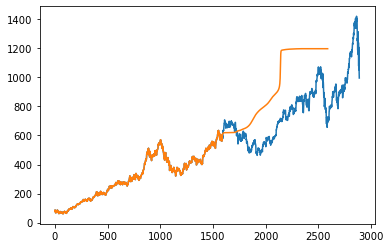

In [40]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-1300], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)